## Dependencies

In [ ]:
import os
import shutil
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Load & Preprocess

In [2]:
keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]

with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

    
with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1, random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
action_categories = sorted(list(set(train_labels)))

In [3]:
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=0, stratify=train_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
val_labels = ['_'.join(name.split('_')[:-1]) for name in val_files]

In [4]:
str_to_int = {"applauding": 0, "climbing": 1, "drinking": 2, "jumping":3 , "pouring_liquid":4, "riding_a_bike":5, "riding_a_horse":6, 
              "running":7, "shooting_an_arrow":8, "smoking":9, "throwing_frisby":10, "waving_hands":11}

y_train = np.array([str_to_int[label] for label in train_labels])
y_val = np.array([str_to_int[label] for label in val_labels])
y_test = np.array([str_to_int[label] for label in test_labels])

In [5]:
x_train = []
for i, file in enumerate(train_files):
    img = cv2.imread(os.path.join('Stanford40/JPEGImages/', file))
    img = cv2.resize(img, (112, 112))
    x_train.append(img)
x_train = np.asarray(x_train)/255.

In [6]:
x_val = []
for i, file in enumerate(val_files):
    img = cv2.imread(os.path.join('Stanford40/JPEGImages/', file))
    img = cv2.resize(img, (112, 112))
    x_val.append(img)
x_val = np.asarray(x_val)/255.

In [7]:
x_test = []
for i, file in enumerate(test_files):
    img = cv2.imread(os.path.join('Stanford40/JPEGImages/', file))
    img = cv2.resize(img, (112, 112))
    x_test.append(img)
x_test = np.asarray(x_test)/255.

In [8]:
# Check dimensions and order
print(len(train_files), len(train_labels))
print(len(val_files), len(val_labels))
print(len(test_files), len(test_labels))
print('\n')
print(y_train[0:3])
print(y_val[0:3])
print(y_test[0:3])

2459 2459
274 274
304 304


[5 7 3]
[7 1 0]
[2 8 2]


## Training & Validation

In [ ]:
# Baseline from Assignment 4
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(112, 112, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=12, activation='softmax')
])

In [1]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

# Save the model's weights
model.save_weights('models/stanford.h5')

NameError: name 'model' is not defined

## Plotting

In [11]:
# Function for plotting accuracy over epochs
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    
# Function for plotting loss over epochs
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

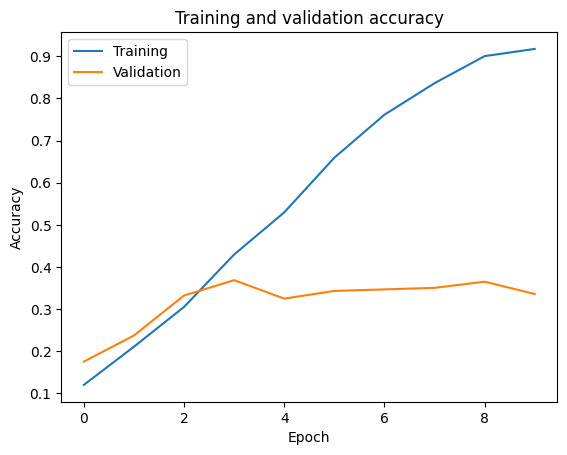

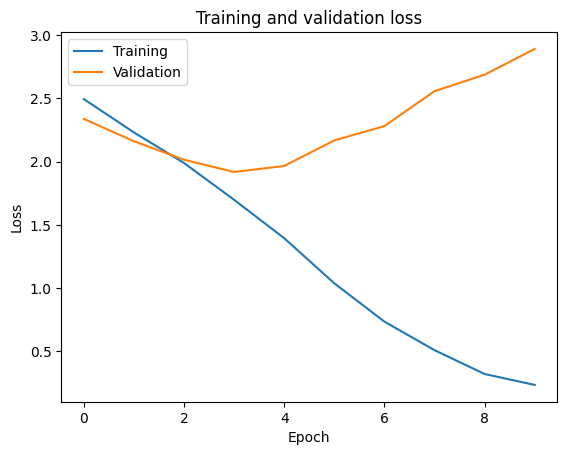

In [12]:
plot_acc(history)
plot_loss(history)

## Testing

In [13]:
result = model.evaluate(x_test, y_test, batch_size=32)
print(result)

10/10 [==============================] - 1s 80ms/step - loss: 3.0881 - accuracy: 0.3750
[3.088050365447998, 0.375]
